# Machine Learning
## Loading Data

In [13]:
import pandas as pd

df = pd.read_parquet('data/ml_data.parquet')
df.head()


,inputs,target,n_posts
0,"[0.45066947, 0.22533473, 0.8637831, 0.13968499...",18,30
1,"[0.4656903, 0.23284516, 0.8537656, -0.02034902...",12,16
2,"[0.48154342, 0.24077171, 0.84270096, 0.3549081...",34,104
3,"[0.48154342, 0.24077171, 0.84270096, -0.196450...",20,35
4,"[0.49827287, 0.24913643, 0.8304548, 0.1336856,...",3,4


## Loading df into torch, train test split

In [26]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Using cuda
my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using ', my_device)

# Create a TensorDataset
inputs = torch.tensor(df['inputs'].tolist(), device=my_device)
targets = torch.tensor(df['target'].values, device=my_device)
dataset = TensorDataset(inputs, targets)

# Split into training and test set
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


We are using  cuda


## Model definitions
### Deep regression network

In [27]:
import torch.nn as nn
import torch.nn.functional as F


class RegressionNN(nn.Module):
    def __init__(self, drop, layer_sizes):
        super(RegressionNN, self).__init__()

        # Create layers dynamically
        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes)-1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

        # Dropout layer
        self.dropout = nn.Dropout(drop)

        # Output layer
        self.output_layer = nn.Linear(layer_sizes[-1], 1)

    def forward(self, x):
        # Forward pass through each layer with ReLU activation and dropout
        for layer in self.layers:
            x = F.relu(layer(x))
            x = self.dropout(x)

        # Forward pass through the output layer
        x = self.output_layer(x)
        return x


## Training loop

In [43]:
import torch
import torch.optim as optim
from tqdm import tqdm

# Training loop
def train(model, epochs, learning_rate, criterion=nn.MSELoss()):
    # Define loss function and optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # loop through epochs
    for epoch in tqdm(range(epochs)):
        losses = []
        model.train()
        total_loss = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(my_device), targets.to(my_device)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs.squeeze(), targets.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        epoch_loss = total_loss/len(train_loader)
        # print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
        losses.append(epoch_loss)
    return losses


## Evaluation
### On test set

In [40]:
def eval_on_test(model, criterion=nn.MSELoss()):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(my_device), targets.to(my_device)
            outputs = model(inputs.float())
            loss = criterion(outputs.squeeze(), targets.float())
            test_loss += loss.item()
    print(f"Test Loss: {test_loss/len(test_loader)}")


### Plotting the loss curve

In [30]:
import matplotlib.pyplot as plt

def plot_losses(losses):
    # Plot the losses
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.show()


### Testing on the current frontpage

In [31]:
import numpy as np
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import requests
import spacy

def get_final_articles_df(date):
    link = f'https://www.derstandard.at/frontpage/{date.strftime('%Y/%m/%d')}'
    # fetch the html content of a derstandard.at page
    response = requests.get(link, cookies={'DSGVO_ZUSAGE_V1': 'true'})
    soup = BeautifulSoup(response.content, 'html.parser')
    # get the articles
    articles_dict = {}
    articles = soup.select('div.chronological>section article')
    for article in articles:
        title_tag = article.find('a')
        if title_tag and title_tag.has_attr('title'):
            title = title_tag['title']
            articles_dict[title] = article
    # make a list of the articles
    HOST = 'https://www.derstandard.at'
    article_data = []
    for title, article in articles_dict.items():
        data = {
            'title': title,
            'teaser-subtitle': None,
            'link': None,
            'time': None,
            'teaser-kicker': None,
            'n_posts': None,
            'storylabels': None
        }
        link = article.find('a')['href']
        if not link.startswith(HOST):
            link = HOST + link
        data['link'] = link
        time = [tag for tag in article.find_all('time') if 'datetime' in tag.attrs][0]
        data['time'] = time['datetime'].rstrip('\r\n')
        n_posts = article.find('div', 'teaser-postingcount')
        try: data['n_posts'] = int(n_posts.get_text(strip=True).rstrip('Posting').replace('.', ''))
        except: data['n_posts'] = 0
        for tag, class_name in [('p', 'teaser-kicker'), 
                                ('p', 'teaser-subtitle'), 
                                ('div', 'storylabels')]:
            found_tag = article.find(tag, class_=class_name)
            if found_tag:
                data[class_name] = found_tag.get_text(strip=True)
        article_data.append(data)
    # make a df
    df = pd.DataFrame(article_data)
    df.columns = df.columns.str.replace('teaser-', '')
    df.rename(columns={'time': 'datetime'}, inplace=True)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['text'] = df['title'] +  df['kicker'].fillna('') + df['subtitle'].fillna('')
    # add embeddings
    nlp = spacy.load("de_core_news_lg")
    df['doc_vector'] = df['text'].apply(lambda t: nlp(t).vector)
    # add date
    def process_row(row):
        date_vector = np.array([
            row['datetime'].month,
            row['datetime'].weekday(),
            row['datetime'].hour
            ])
        # Normalize the date_vector, ensure it is float32 like the doc vectors
        norm_date_vector = (date_vector / np.linalg.norm(date_vector)).astype(np.float32)
        return np.concatenate((norm_date_vector, row['doc_vector']))
    df['inputs'] = df.apply(process_row, axis=1)
    return df


def compare_prediction_for_date(model, date):
    # fetch articles for the date
    articles = get_final_articles_df(date)
    target_map = pd.read_csv('data/target_map.csv')

    for i, row in articles.iterrows():
        input_data = torch.tensor(row['inputs'], dtype=torch.float)
        input_data = input_data.to(next(model.parameters()).device)

        # Reshape the input data and pass it through the model
        input_data = input_data.unsqueeze(0)  # Add a batch dimension
        with torch.no_grad():
            output = model(input_data)

        target_index = int(output.item())
        predicted_b = target_map.iloc[target_index]['bounds']
        actual = row['n_posts']
        print(f"Predicted: {predicted_b}, Actual: {actual}")

### Wrapping it all into a single function

In [32]:
def eval_trained_model(model, losses, date):
    plot_losses(losses)
    eval_on_test(model)
    compare_prediction_for_date(model, date)

## Testing different models

In [33]:
# pick test date one week ago
test_date = datetime.now() - timedelta(days=7)

### Small regression Model

In [44]:
small_model = RegressionNN(
    drop = 0.3,
    layer_sizes = [303, 128, 64]
    ).to(my_device)

print('training small model')
small_losses = train(small_model, epochs=10, learning_rate=0.001)
print('evaluating small model')
eval_trained_model(small_model, small_losses, test_date)

training small model


 80%|████████  | 8/10 [01:54<00:31, 15.53s/it]

### Big regression Model

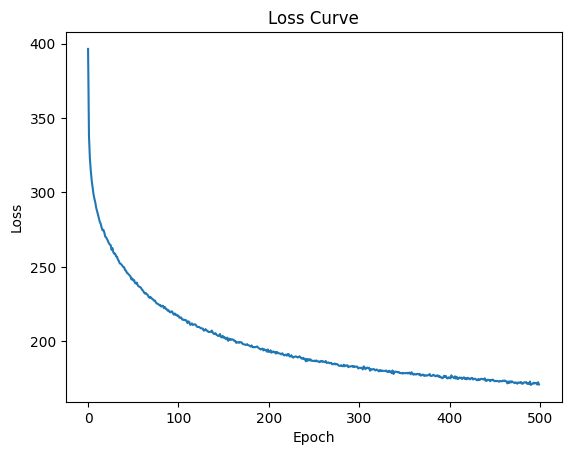

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [23]:
# big_model = RegressionNN(
#     drop = 0.5,
#     layer_sizes = [303, 303, 256, 256, 256, 128, 128, 64]
#     ).to(my_device)

# big_losses = train(big_model, epochs=10)
eval_trained_model(model, losses, test_date)

## Saving the models

In [ ]:
def save_model(model, name):
    path = f'models/{name}.pth'
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


Model saved to big_reg_model.pth
